In [10]:
import msprime
import tskit
import numpy as np

import os
import subprocess

import pandas as pd

import math 
import statistics

import seaborn as sns
from IPython.display import SVG, set_matplotlib_formats
from matplotlib import pyplot as plt

from collections import Counter

import pickle

## Functions definitions

In [11]:
HetATypes = [ # when a mutation is ancestral to any of these lists of leaves, it is a hetA mutation
    [0],
    [1],
    [0,2,3], # [0, 2, 3] is equivalent to [1] on an unrooted tree
    [1,2,3]
]
HetBTypes = [
    [2],
    [3],
    [0,1,2],
    [0,1,3]
]
FixedDiffs = [
    [0,1],
    [2,3]
]
HetABTypes = [
    [0,2],
    [0,3],
    [1,2],
    [1,3]
]

mutTypeDict = {(0,1,2,3):None};
for ls in HetATypes:
    mutTypeDict[tuple(sorted(ls))] = "hetA"
for ls in HetBTypes:
    mutTypeDict[tuple(sorted(ls))] = "hetB"
for ls in HetABTypes:
    mutTypeDict[tuple(sorted(ls))] = "hetAB"
for ls in FixedDiffs:
    mutTypeDict[tuple(sorted(ls))] = "FD"

In [12]:
def calculate_asymmetry(a_list, b_list):
    
    a_total = sum(a_list)
    b_total = sum(b_list)

    asymm = (a_total - b_total) / (a_total + b_total)

    return asymm

In [13]:
def block_jackknife(a_list, b_list, jk_block):
    total_jk_blocks = int((len(a_list) - (len(a_list) % jk_block)) / jk_block)
    #print("total_jk_blocks= ", total_jk_blocks)
    if total_jk_blocks < 2:
        #print("not enough blocks for jackknife")
        overall_estimate = calculate_asymmetry(a_list, b_list)
        return [-1, overall_estimate,1]
    trimmed_a_list = a_list[:total_jk_blocks * jk_block]
    trimmed_b_list = b_list[:total_jk_blocks * jk_block]
    blocked_a_list = np.mean(trimmed_a_list.reshape(-1, jk_block), axis=1)
    blocked_b_list = np.mean(trimmed_b_list.reshape(-1, jk_block), axis=1)
    overall_estimate = calculate_asymmetry(blocked_a_list, blocked_b_list)
    n = total_jk_blocks
    pseudo_estimates = []
    for i in range(0, n):
        retained_a_blocks = np.delete(blocked_a_list, i)
        retained_b_blocks = np.delete(blocked_b_list, i)
        retained_blocks_estimate = calculate_asymmetry(retained_a_blocks, retained_b_blocks)
        pseudo_estimate = (n * overall_estimate) - ((n - 1) * retained_blocks_estimate)
        pseudo_estimates.append(pseudo_estimate)
    pseudovalue_variance = sum([(e - overall_estimate)**2 for e in pseudo_estimates]) / (n - 1)
    lower_CI = overall_estimate - (1.96 * math.sqrt(pseudovalue_variance / n))
    higher_CI = overall_estimate + (1.96 * math.sqrt(pseudovalue_variance / n))
    return [lower_CI, overall_estimate, higher_CI]

In [14]:
def boolIncongruent_a_b_from_tree(tree):
    tempList = []
    for node in tree.nodes():
        leaves = tuple(sorted(list(tree.leaves(node))))
        mutType = mutTypeDict[leaves]
        length = tree.get_branch_length(node)
        tempList.append([mutType,length])

    if 'hetAB' in [a for [a,b] in tempList]:
        incongruentBool = 1
    else:
        incongruentBool = 0.0
    # calculate the total length of hetA and hetB type branches in this tree
    a_length = sum([y for x,y in tempList if x=='hetA'])
    b_length = sum([y for x,y in tempList if x=='hetB'])

    return incongruentBool, a_length, b_length

In [15]:
def genotype_to_branch_type(genotype_arr): #takes a numpy array of length 4 indicating the lineages ancestral to the sample
    x = np.array([0,1,2,3])
    y = x[genotype_arr==1]
    mutType = mutTypeDict[tuple(sorted(y))]
    return mutType

In [16]:
def calculate_stuff_jackknife(resultsAtDistance,jkblock):
    probIncongruent = sum(resultsAtDistance[:,0])/len(resultsAtDistance)
    probCongruent = 1 - probIncongruent
    
    #  A_i from the  manuscript is AI.  and the _all, _cong, and _incong are for the subsets of the data

    ta = resultsAtDistance[:,1]
    tb = resultsAtDistance[:,2]

    AI_all = block_jackknife(ta,tb,jkblock)

    if probIncongruent >0:
        incongResults = resultsAtDistance[resultsAtDistance[:,0]==1]
        ta_incong = incongResults[:,1]
        tb_incong = incongResults[:,2]
        AI_incong = block_jackknife(ta_incong,tb_incong,jkblock)
    else:
        AI_incong = [math.nan,math.nan,math.nan]

    if probCongruent>0:
        congResults = resultsAtDistance[resultsAtDistance[:,0]==0]
        ta_cong = congResults[:,1]
        tb_cong = congResults[:,2]
        AI_cong = block_jackknife(ta_cong,tb_cong,jkblock)
    else:
        AI_cong =  [math.nan,math.nan,math.nan]
        
    
    return probIncongruent,probCongruent,AI_all, AI_incong, AI_cong


## Results -- with migration

In [17]:
mu = 1e-8
r = 1e-8
Na = 1e5
Nb = 1e5*2
Nanc = 1e5
M = 1.0 / (2 * Na)
Tsplit = 2e5 #generations

demography = msprime.Demography()
demography.add_population(name="A", initial_size=Na)
demography.add_population(name="B", initial_size=Nb)
demography.add_population(name="C", initial_size=Nanc)
demography.add_population_split(time=Tsplit, derived=["A", "B"], ancestral="C")
demography.set_migration_rate(source="A",dest="B",rate = M)

numTreeSims = 250_000

distances = [0]+[2**i for i in range(0,17)]
results_dict = {}
for dist in distances:
    results_dict[dist] = np.zeros((numTreeSims,3)) # [ 0/1 bool (1 if incongruent), Ta in generations, Tb in generations]
L = 2*distances[-1]+10

print(distances)
print(L)


[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]
131082


In [557]:
for i in range(numTreeSims):
    
    firstHetABMutationPosition = -1
    limiter = 0
    while firstHetABMutationPosition<0 or firstHetABMutationPosition>L/2:
        limiter = limiter+1
        if limiter>50:
            break
        ts = msprime.sim_ancestry(
        samples={"A": 1, "B": 1}, 
        demography=demography,
        ploidy=2,
        recombination_rate=r,
        sequence_length=L,
        discrete_genome=True, # means genelogies have defined coords
        record_migrations=True
        )
    
        mts = msprime.sim_mutations(ts, rate=mu, discrete_genome=False)
    
        for var in mts.variants():
            genotype = var.genotypes
            # if sum(genotype)==0.0:
            #     print(genotype)
            #     next
            # if sum(genotype)==4.0:
            #     print(genotype)
            #     next
            mutType = genotype_to_branch_type(var.genotypes)
            if mutType == 'hetAB':
                firstHetABMutationPosition = int(var.position)
                break
    for dist in distances:
        rightPos = firstHetABMutationPosition + dist
        if firstHetABMutationPosition == -1:
            print("failed no hetAB mutation", i, firstHetABMutationPosition)
            break
        if rightPos > L:
            print("failed too far right", i, rightPos)
            break
        thisTree = ts.at(rightPos)
        results_dict[dist][i]=np.array(boolIncongruent_a_b_from_tree(thisTree))


In [25]:
aiAllList = [];
pIncList = [];
pCongList = [];
aiIncongList = [];
aiCongList = [];

for dist in distances:
    pInc,pCong,ai_all,ai_incong,ai_cong = calculate_stuff_jackknife(results_dict[dist],50)
    aiAllList.append(ai_all)
    pIncList.append(pInc)
    pCongList.append(pCong)
    aiIncongList.append(ai_incong)
    aiCongList.append(ai_cong)

aiAllList = np.array(aiAllList).transpose()
aiIncongList = np.array(aiIncongList).transpose()
aiCongList = np.array(aiCongList).transpose()

aAllMeans = aiAllList[1]
aAllErr = [abs(aiAllList[1]-aiAllList[0]),abs(aiAllList[2]-aiAllList[1])]

aIncongMeans = aiIncongList[1]
aIncongErr = [abs(aiIncongList[1]-aiIncongList[0]),abs(aiIncongList[2]-aiIncongList[1])]
 
aCongMeans = aiCongList[1]
aCongErr = [abs(aiCongList[1]-aiCongList[0]),abs(aiCongList[2]-aiCongList[1])]



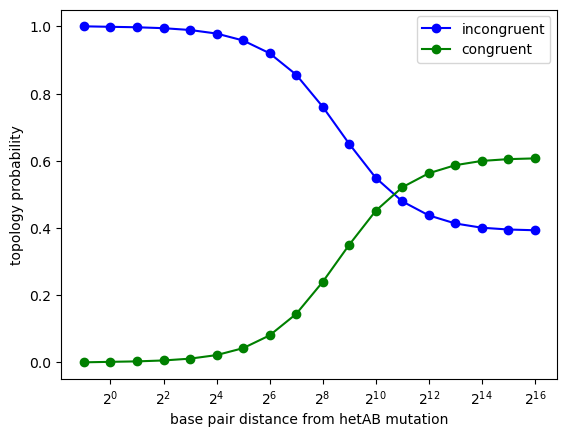

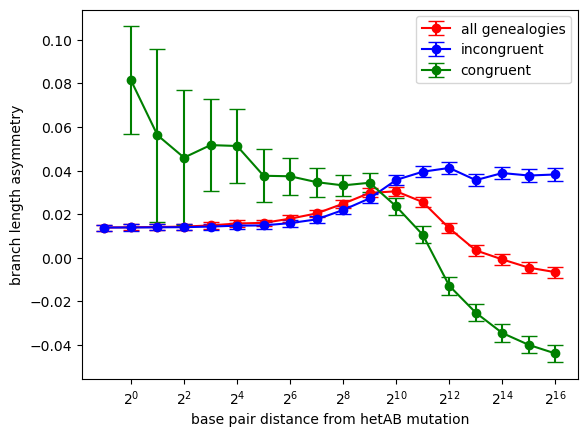

In [26]:

distancesLog2 = distances.copy()
distancesLog2[0]=1/2


fig,ax = plt.subplots()
ax.plot(distancesLog2,pIncList,color='b',marker='o',label = 'incongruent')
ax.plot(distancesLog2,pCongList,color='g',marker='o',label = 'congruent')
ax.set_xscale('log', base=2)
plt.xlabel('base pair distance from hetAB mutation')
plt.ylabel('topology probability')
ax.legend()
plt.show()


fig,ax = plt.subplots()
ax.errorbar(distancesLog2,aAllMeans,yerr=aAllErr,fmt='-o',color='r',label='all genealogies',capsize=6)
ax.errorbar(distancesLog2,aIncongMeans,yerr=aIncongErr,fmt='-o',color='b',label='incongruent',capsize=6)
ax.errorbar(distancesLog2,aCongMeans,yerr=aCongErr,fmt='-o',color='g',label='congruent',capsize=6)
plt.xlabel('base pair distance from hetAB mutation')
plt.ylabel('branch length asymmetry')
plt.xscale('log',base=2)
ax.legend()
plt.show()

## Results -- no migration

In [27]:
mu = 1e-8
r = 1e-8
Na = 1e5
Nb = 1e5*2
Nanc = 1e5
M = 1.0 / (2 * Na)
Tsplit = 2e5 #generations

demography = msprime.Demography()
demography.add_population(name="A", initial_size=Na)
demography.add_population(name="B", initial_size=Nb)
demography.add_population(name="C", initial_size=Nanc)
demography.add_population_split(time=Tsplit, derived=["A", "B"], ancestral="C")

numTreeSims = 250_000

distances = [0]+[2**i for i in range(0,17)]
results_dict_no_mig = {}
for dist in distances:
    results_dict_no_mig[dist] = np.zeros((numTreeSims,3)) # [ 0/1 bool (1 if incongruent), Ta in generations, Tb in generations]
L = 2*distances[-1]+10

print(distances)
print(L)

[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]
131082


In [640]:


for i in range(numTreeSims):
    
    firstHetABMutationPosition = -1
    limiter = 0
    while firstHetABMutationPosition<0 or firstHetABMutationPosition>L/2:
        limiter = limiter+1
        if limiter>100:
            break
        ts = msprime.sim_ancestry(
        samples={"A": 1, "B": 1}, 
        demography=demography,
        ploidy=2,
        recombination_rate=r,
        sequence_length=L,
        discrete_genome=True, # means genelogies have defined coords
        record_migrations=True
        )
    
        mts = msprime.sim_mutations(ts, rate=mu, discrete_genome=False)
    
        for var in mts.variants():
            genotype = var.genotypes
            # if sum(genotype)==0.0:
            #     print(genotype)
            #     next
            # if sum(genotype)==4.0:
            #     print(genotype)
            #     next
            mutType = genotype_to_branch_type(var.genotypes)
            if mutType == 'hetAB':
                firstHetABMutationPosition = int(var.position)
                break
    for dist in distances:
        rightPos = firstHetABMutationPosition + dist
        if firstHetABMutationPosition == -1:
            print("failed no hetAB mutation", i, firstHetABMutationPosition)
            break
        if rightPos > L:
            print("failed too far right", i, rightPos)
            break
        thisTree = ts.at(rightPos)
        results_dict_no_mig[dist][i]=np.array(boolIncongruent_a_b_from_tree(thisTree))




In [29]:


aiAllList = [];
pIncList = [];
pCongList = [];
aiIncongList = [];
aiCongList = [];

for dist in distances:
    pInc,pCong,ai_all,ai_incong,ai_cong = calculate_stuff_jackknife(results_dict_no_mig[dist],50)
    aiAllList.append(ai_all)
    pIncList.append(pInc)
    pCongList.append(pCong)
    aiIncongList.append(ai_incong)
    aiCongList.append(ai_cong)


aiAllList = np.array(aiAllList).transpose()
aiIncongList = np.array(aiIncongList).transpose()
aiCongList = np.array(aiCongList).transpose()

aAllMeans = aiAllList[1]
aAllErr = [abs(aiAllList[1]-aiAllList[0]),abs(aiAllList[2]-aiAllList[1])]

aIncongMeans = aiIncongList[1]
aIncongErr = [abs(aiIncongList[1]-aiIncongList[0]),abs(aiIncongList[2]-aiIncongList[1])]
 
aCongMeans = aiCongList[1]
aCongErr = [abs(aiCongList[1]-aiCongList[0]),abs(aiCongList[2]-aiCongList[1])]


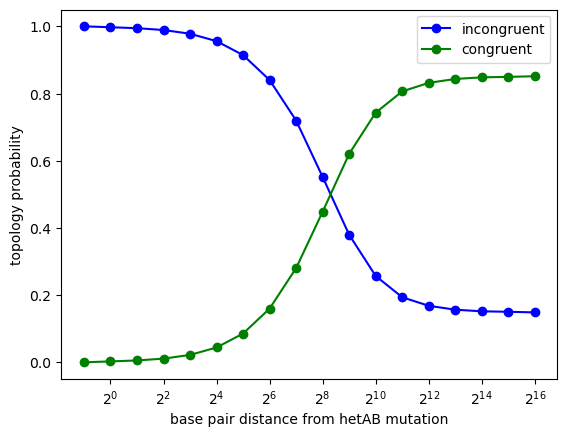

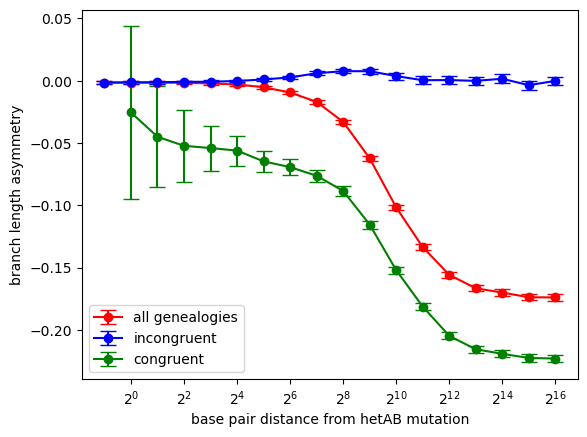

In [30]:
distancesLog2 = distances.copy()
distancesLog2[0]=1/2

fig,ax = plt.subplots()
ax.plot(distancesLog2,pIncList,color='b',marker='o',label = 'incongruent')
ax.plot(distancesLog2,pCongList,color='g',marker='o',label = 'congruent')
ax.set_xscale('log', base=2)
plt.xlabel('base pair distance from hetAB mutation')
plt.ylabel('topology probability')
ax.legend()
plt.show()


fig,ax = plt.subplots()
ax.errorbar(distancesLog2,aAllMeans,yerr=aAllErr,fmt='-o',color='r',label='all genealogies',capsize=6)
ax.errorbar(distancesLog2,aIncongMeans,yerr=aIncongErr,fmt='-o',color='b',label='incongruent',capsize=6)
ax.errorbar(distancesLog2,aCongMeans,yerr=aCongErr,fmt='-o',color='g',label='congruent',capsize=6)
plt.xlabel('base pair distance from hetAB mutation')
plt.ylabel('branch length asymmetry')
plt.xscale('log',base=2)
ax.legend()
plt.show()